In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from natsort import natsorted, ns, natsort_keygen
import os
import pandas as pd
import PIL as pillow
from PIL import Image
import cv2
from PIL import Image, ImageFont, ImageDraw 

In [2]:
path = os.getcwd()
datum_files = [f for f in os.listdir(path) if f.startswith('Datum') and f.endswith('.txt')]
datum_files = natsorted(datum_files) # sort files naturally, i.e. 1, 2, 11, 22, ...

In [3]:
datum_files_num = len(datum_files)

for i in range(datum_files_num):
    f = open(datum_files[0])
    f_new = open('new_'+datum_files[i],"w+")
    f_lines = f.readlines()
    f_lines_num = len(f_lines)
    
    for j in range(f_lines_num):
        f_one_line = f_lines[j].split()
        
        if float(f_one_line[0]) <= 730*3600:
            f_new.write(str(float(f_one_line[0])/3600))
            f_new.write(' ')
            f_new.write(f_one_line[1])
            f_new.write(' ')
            f_new.write(f_one_line[2])
            f_new.write(' ')
            f_new.write(f_one_line[3])
            f_new.write('\n')
        
    f_new.close()
    f.close()

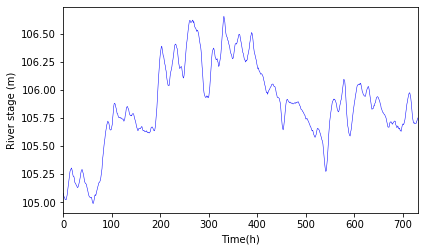

In [5]:
river_datum = pd.read_csv('new_'+datum_files[0], sep=" ", header=None, names=['time', 'x', 'y', 'wl'],delimiter=r"\s+")
fig, ax1 = plt.subplots(1, 1)

river_datum.plot(x='time', y='wl',color= 'blue',linewidth = 0.5, ax=ax1, legend=None)

ax1.set_ylabel('River stage (m)')
ax1.set_xlabel('Time(h)')

# ax1.legend(handles=legend_elements, loc='best')
fig.tight_layout()
fig.set_size_inches(6, 3.5)

In [6]:
f_time = open(path+'/pflotran_time.txt')
f_time_lines = f_time.readlines()
f_time_l = len(f_time_lines)
times = []

for i in range(f_time_l-1):
    a = f_time_lines[i+1].split()
    times.append(float(a[1]))
    
times.sort()
f_time.close()

In [30]:
def get_concat_h_cut(im_1, im_2):
    dst = Image.new('RGB', (im_1.width + im_2.width, min(im_1.height, im_2.height)))
    dst.paste(im_1, (0, 0))
    dst.paste(im_2, (im_1.width, 0))
    return dst

def get_concat_v_cut(im_1, im_2):
    dst = Image.new('RGB', (max(im_1.width, im_2.width), im_1.height + im_2.height))
    dst.paste(im_1, (0, 0))
    dst.paste(im_2, (0, im_1.height))
    return dst

In [95]:
# real_list = ['R21','R41','R61','R81','R100','R101','R121','R141','R161','R181','R200']
real_list = ['R200']

In [96]:
font_title = ImageFont.truetype(r'/global/cscratch1/sd/vthw28/Image/arialbd.ttf', 60) 
font_axis = ImageFont.truetype(r'/global/cscratch1/sd/vthw28/Image/arialbd.ttf', 37) 
time_step_num = len(times)
real_num = len(real_list)
folder_name_check = os.listdir('/global/cscratch1/sd/vthw28/Image/')

for j in range(real_num): 
    image_folder = 'Paraview_'+real_list[j]
    result_folder_name = 'Result_'+real_list[j]
    
    ct = 0
    for itime in times[:]:
        print(itime)
        ct += 1
        fig, ax1 = plt.subplots(1, 1)

        river_datum.plot(x='time', y='wl',color= 'blue',linewidth = 1.5, ax=ax1, legend=None)

        # add moving time tick
        ax1.plot((itime, itime), (104, 108), 'r-')

        ax1.set_ylabel('River stage (m)',fontweight = 'bold')
        ax1.set_xlabel('Time(h)',fontweight = 'bold')
    
        f = open('new_DatumH_River_Plume2013.txt')
        f_time_lines = f.readlines()
        f_time_l = len(f_time_lines)
    
        for i in range(f_time_l):
            if itime == float(f_time_lines[i].split()[0]):
                title_ex = f_time_lines[i].split()[3]
                title_ex_float = str(float("{0:.2f}".format(float(title_ex))))
                title = real_list[j]+' - '+str(int(itime))+' h - '+title_ex_float+' m'
            
        ax1.set_title(title, fontsize = 14,fontweight = 'bold')

        ax1.set_xlim(0, 735)
        ax1.set_ylim([104, 108])
        plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0, ha = 'center')

        # ax1.legend(handles=legend_elements, loc='best')
        fig.tight_layout()
        fig.set_size_inches(10, 2.9)

        fig.savefig('River_Stage/'+'River_Stage_' + str(int(itime))+'.jpg'.format(ct), dpi=300)
        plt.close(fig)
    
    if result_folder_name in folder_name_check:
        print('The directory named', '\x1b[0;30;41m'+result_folder_name+'\x1b[0m','has existed.')
    else:
        os.mkdir(result_folder_name)
        print ('Successfully created the directory', '\x1b[0;30;42m'+result_folder_name+'\x1b[0m')
    
    for i in range(time_step_num):
        # creating a image object 
        time_4_digitals = str(i).zfill(4)
        Paraview_image_name = 'test_'+real_list[j]+'.'+time_4_digitals+'.png'
        image = Image.open(r'/global/cscratch1/sd/vthw28/Image/'+image_folder+'/'+Paraview_image_name)  
  
        draw = ImageDraw.Draw(image)

        # title top left
        text = 'Elevation = 104 m'
        draw.text((738, 50), text, font = font_title,fill=(0,0,0)) 

        # title top right
        text = 'Elevation = 103 m'
        draw.text((2682, 50), text, font = font_title,fill=(0,0,0)) 

        # title bot left
        text = 'Elevation = 102 m'
        draw.text((738, 1632), text, font = font_title,fill=(0,0,0)) 

        # x-axis name top left
        text = 'Easting (m)'
        draw.text((878, 1541), text, font = font_axis,fill=(0,0,0)) 

        # x-axis name top right
        text = 'Easting (m)'
        draw.text((2822, 1541), text, font = font_axis,fill=(0,0,0)) 

        # x-axis name bot left
        text = 'Easting (m)'
        draw.text((878, 3123), text, font = font_axis,fill=(0,0,0)) 

        # title bot right top
        text = 'Northing = 100 m'
        draw.text((2705, 1632), text, font = font_title,fill=(0,0,0)) 

        # title bot right bot
        text = 'Northing = 200 m'
        draw.text((2705, 2265), text, font = font_title,fill=(0,0,0)) 

        # x-axis name bot right top
        text = 'Easting (m)'
        draw.text((2822, 2100), text, font = font_axis,fill=(0,0,0)) 

        # x-axis name bot right bot
        text = 'Easting (m)'
        draw.text((2822, 2733), text, font = font_axis,fill=(0,0,0)) 
    
        image_add_title_axis = 'Result_Part1.png'
  
        image.save(image_add_title_axis)

        # Add line
        im1path = '/global/cscratch1/sd/vthw28/Image/'+image_add_title_axis
        img1 = cv2.imread(im1path)

        # top left
        ptStart = (316,793)
        ptEnd = (1624, 793)
        point_color = (0, 0, 0)
        thickness = 2 
        lineType = 4
        cv2.line(img1, ptStart, ptEnd, point_color, thickness, lineType)

        ptStart = (316,1120)
        ptEnd = (1624, 1120)
        point_color = (0, 0, 0)
        thickness = 2 
        lineType = 4
        cv2.line(img1, ptStart, ptEnd, point_color, thickness, lineType)

        # bot left
        ptStart = (316,2375)
        ptEnd = (1624, 2375)
        point_color = (0, 0, 0)
        thickness = 2 
        lineType = 4
        cv2.line(img1, ptStart, ptEnd, point_color, thickness, lineType)

        ptStart = (316,2702)
        ptEnd = (1624, 2702)
        point_color = (0, 0, 0)
        thickness = 2 
        lineType = 4
        cv2.line(img1, ptStart, ptEnd, point_color, thickness, lineType)

        # top right
        ptStart = (2260,793)
        ptEnd = (3568, 793)
        point_color = (0, 0, 0)
        thickness = 2 
        lineType = 4
        cv2.line(img1, ptStart, ptEnd, point_color, thickness, lineType)

        ptStart = (2260,1120)
        ptEnd = (3568, 1120)
        point_color = (0, 0, 0)
        thickness = 2 
        lineType = 4
        cv2.line(img1, ptStart, ptEnd, point_color, thickness, lineType)

        image_add_line = 'Part2_Result.png'
        im2path = '/global/cscratch1/sd/vthw28/Image/'+image_add_line
        cv2.imwrite(im2path,img1)

        # y-axis name top left

        text = 'Northing (m)'
        width, height = font_axis.getsize(text)

        image1 = Image.open(r'/global/cscratch1/sd/vthw28/Image/'+image_add_line)  
        draw1 = ImageDraw.Draw(image1)

        image2 = Image.new('RGBA', (230, 50), (255, 255, 255, 0))
        draw2 = ImageDraw.Draw(image2)
        draw2.text((10, 10), text=text, font=font_axis, fill=(0, 0, 0))

        image2 = image2.rotate(90, expand=1)

        image1.paste(image2, (140,685))
        image1.paste(image2, (2084,685))
        image1.paste(image2, (140,2267))

        text = 'Elevation (m)'
        image3 = Image.new('RGBA', (245, 50), (255, 255, 255, 0))
        draw3 = ImageDraw.Draw(image3)
        draw3.text((10, 10), text=text, font=font_axis, fill=(0, 0, 0))

        image3 = image3.rotate(90, expand=1)

        image1.paste(image3, (2084,1747))
        image1.paste(image3, (2084,2380))

        image_result = 'Bot_Result.png'
        image1.save(image_result)
    
        im1 = Image.open(image_result)
        w1,h1 = im1.size

        river_stage_name = 'River_Stage_'+str(int(times[i]))+'.jpg'
        im2 = Image.open('/global/cscratch1/sd/vthw28/Image/River_Stage/'+river_stage_name)
        w2,h2 = im2.size
    
        img = Image.new('RGB', (int((w1-w2)*0.4), h1), (255, 255, 255))
        img.save('bg_right.png')
        img = Image.new('RGB', (w1-w2-int((w1-w2)*0.4), h1), (255, 255, 255))
        img.save('bg_left.png')

        im1 = Image.open('bg_left.png')
    
        save_image_name = 'test_top_1.png'
        get_concat_h_cut(im2, im1).save(path+'/'+save_image_name)
    
        im1 = Image.open('test_top_1.png')

        im2 = Image.open('bg_right.png')
    
        save_image_name = 'test_top.png'
        get_concat_h_cut(im2, im1).save(path+'/'+save_image_name)
    
        im1 = Image.open(image_result)

        im2 = Image.open('test_top.png')
            
        save_image_name = result_folder_name+'/Result_'+Paraview_image_name
        get_concat_v_cut(im2, im1).save(path+'/'+save_image_name)
        
        print('Currently processing results from','\x1b[0;30;42m'+real_list[j]+'\x1b[0m','. Time step:','\x1b[0;30;42m'+str(int(times[i]))+'\x1b[0m','h has finished.')

23.0
122.0
151.0
171.0
193.0
221.0
270.0
291.0
316.0
336.0
365.0
372.0
387.0
408.0
436.0
574.0
581.0
588.0
595.0
656.0
663.0
670.0
677.0
683.0
690.0
697.0
719.0
726.0
730.0
Successfully created the directory Result_R200
Currently processing results from R200 . Time step: 23 h has finished.
Currently processing results from R200 . Time step: 122 h has finished.
Currently processing results from R200 . Time step: 151 h has finished.
Currently processing results from R200 . Time step: 171 h has finished.
Currently processing results from R200 . Time step: 193 h has finished.
Currently processing results from R200 . Time step: 221 h has finished.
Currently processing results from R200 . Time step: 270 h has finished.
Currently processing results from R200 . Time step: 291 h has finished.
Currently processing results from R200 . Time step: 316 h has finished.
Currently processing results from R200 . Time step: 336 h has finished.
Currently processing results from R200 . Time step: 365 h has

In [ ]:
# convert -delay 150(time_interval) -loop 1(repeat_number) test_*.jpg test.gif